We import the libraries and features needed to run this project. We also include a line to make matplotlib function in the jupyter notebook.   

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pydst
import ipywidgets as widgets
from matplotlib import pyplot as plt
import scipy.stats
import tkinter as tk
import tkinter as tk

Dst = pydst.Dst(lang='en')

We receive data from an api through "DST", with some restriction to avoid data cleaning. 

In [2]:
account = Dst.get_data(table_id = "REGK11", variables = {"OMRÅDE": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
budget = Dst.get_data(table_id = "BUDK1", variables = {"REGI07A": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
people = Dst.get_data(table_id = "INDAMP01", variables = {"OMRÅDE": ["*"], "KØN": ["TOT"], "ALDER": ["TOT"], "PERSG": ["IALT"], "Tid": ["*"], "BNØGLE": ["PER"]})

In [3]:
account.head()

,OMRÅDE,FUNK1,DRANST,ART,PRISENHED,TID,INDHOLD
0,Hillerød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,62180
1,Solrød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53166
2,Dragør,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53794
3,Gribskov,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,61529
4,Gentofte,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,54695


We see that the dataframe has some not usefull columns, which we drop. 

In [4]:
account.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
budget.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
people.drop(["KØN", "ALDER", "PERSG", "BNØGLE"], axis=1, inplace=True)

account.head()

,OMRÅDE,TID,INDHOLD
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


We rename the columns.

In [5]:
budget.rename(columns = {"REGI07A":"Municipality", "TID": "Year", "INDHOLD":"Budget"}, inplace = True)
account.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"Account"}, inplace = True)
people.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"People"}, inplace = True)

account.head()

,Municipality,Year,Account
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


In [6]:
budget.info()
account.info()
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 3 columns):
Municipality    1144 non-null object
Year            1144 non-null int64
Budget          1144 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 3 columns):
Municipality    832 non-null object
Year            832 non-null int64
Account         832 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 3 columns):
Municipality    1380 non-null object
Year            1380 non-null int64
People          1380 non-null int64
dtypes: int64(2), object(1)
memory usage: 32.4+ KB


In this project we focus on the surplus which is budget - account, and therefore we need data for both account and budget in the same year. 
Since we not have data for all years we only use data for the years from 2011 - 2017 to calculate the surplus. 
We only need data for municipalities and therefore we exclude the Region, Province and All Denmark. 


In [7]:
for val in ["Region", "Province", "All Denmark"]:
    for count, dataset in enumerate([people, budget, account]):
        rowstodrop = dataset.loc[lambda df: df["Municipality"].str.contains(val)].index
        dataset.drop(rowstodrop, axis=0, inplace=True)

a = []
for i in range(2011,2018):
    a.append(str(i))

budget = budget.loc[budget["Year"].isin(a)]
people = people.loc[people["Year"].isin(a)]
account = account.loc[account["Year"].isin(a)]


In [8]:
budget.info()
people.info()
account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 888
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Budget          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 1378
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
People          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 831
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Account         686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


We see that our dataframes got the same dimension in the .info() .
Now we need to merge the data into one dataframe. 


In [9]:
partialmerge = pd.merge(people, account, how="outer", on=["Municipality", "Year"])
fullymerged = pd.merge(partialmerge, budget, how="outer", on=["Municipality", "Year"])
fullymerged.head()

,Municipality,Year,People,Account,Budget
0,Holbæk,2011,69521,61203,61099
1,Faxe,2011,35277,59814,59963
2,Kalundborg,2011,49088,66668,66307
3,Ringsted,2011,32890,61444,62650
4,Slagelse,2011,77442,63393,63924


We need to add a column with the surplus, which is budget - account. 

In [10]:
fullymerged["Surplus"] = fullymerged["Budget"]-fullymerged["Account"]
fullymerged[fullymerged["Municipality"]=="Aalborg"].head()

,Municipality,Year,People,Account,Budget,Surplus
63,Aalborg,2011,199188,61958,62758,800
161,Aalborg,2012,201142,64535,65523,988
259,Aalborg,2013,203448,60966,61530,564
390,Aalborg,2014,205809,60002,60343,341
488,Aalborg,2015,207805,60893,60157,-736


It seems that there is no link between Surplus and people. 
we want to see if surplus is normal distributed. we see that this is not the case, but more like the municipalities tries to get a little surplus each year which is inefficient for the community.

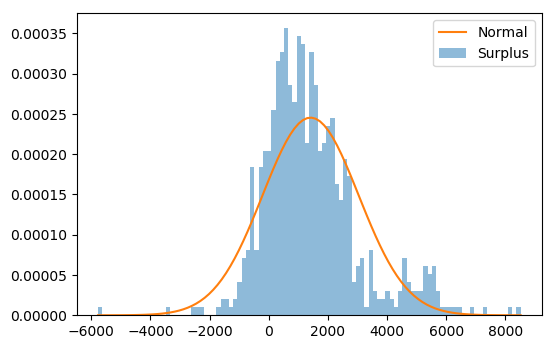

In [11]:
mean = np.mean(fullymerged["Surplus"])
variance = np.var(fullymerged["Surplus"])
sigma = np.sqrt(variance)

x = np.linspace(min(fullymerged["Surplus"]), max(fullymerged["Surplus"]), 100)


fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)
ax.hist(fullymerged["Surplus"], density=True, bins = 100, alpha = 0.5, label = "Surplus")
ax.plot(x, scipy.stats.norm.pdf(x, mean, sigma), label = "Normal")
ax.legend()

 

Now we plot surplus agianst people to see if there is some link between. 


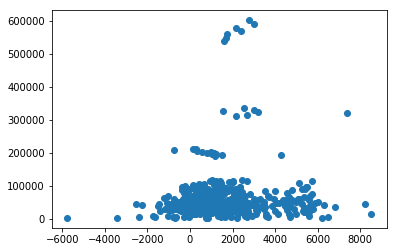

In [12]:
plt.scatter(fullymerged["Surplus"], fullymerged["People"])
plt.show()

In [14]:
from NokiaSnakeClient import graphwindow   

app = graphwindow(data=fullymerged, x="Year",y="Surplus",y2="People",graphnames="Municipality")
app.geometry("1280x720")
app.mainloop()

interactive(children=(Dropdown(description='Municipality', options=('Aabenraa', 'Aalborg', 'Aarhus', 'Albertsl…

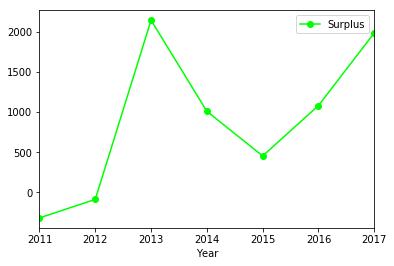

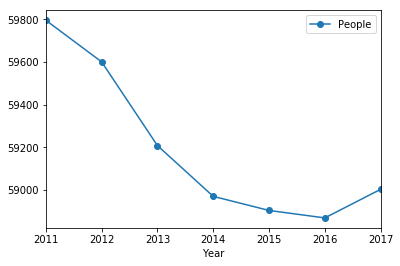

In [11]:
def plot_e(dataframe, municipality): 
    I = dataframe['Municipality'] == municipality
    ax = dataframe.loc[I,:]
    
    
    ax.plot(x='Year', y="Surplus", style='-o', color="#00FF00", legend='False')
    ax.plot(x='Year', y="People", style='-o', legend='False')
    
widgets.interact(plot_e, 
    dataframe = widgets.fixed(fullymerged),
    municipality = widgets.Dropdown(description='Municipality', options=sorted(fullymerged.Municipality.unique()))
); 